# **Machine Learning Applications in Portfolio Optimisation**


## **Table of Contents**

---

### **1.** [**Background and Motivation**](#11-background-and-motivation)
   * [Research Objectives](#12-research-objectives)
   
---

### **2.** [**Data Retrieval and Preprocessing**](#21-data-retrieval-and-preprocessing)
   * [Exploratory Data Analysis (EDA)](#22-exploratory-data-analysis-eda)

---

### **3.** [**Mean Variance Optimisation (MVO)**](#31-mean-variance-optimisation-mvo)
   * [Assumptions and Limitations of MVO](#32-assumptions-and-limitations-of-mvo)
   * [Optimum Weights](#33-optimum-weights)
   * [Sharpe Ratio](#34-sharpe-ratio)
   * [Efficient Frontier](#35-efficient-frontier)
   * [Optimised Portfolio Analysis](#36-optimised-portfolio-analysis)

---

### **4.** [**Capital Asset Pricing Model (CAPM)**](#41-capital-asset-pricing-model-capm)
   * [Assumptions and Limitations of CAPM](#42-assumptions-and-limitations-of-capm)
   * [Security Market Line (SML)](#43-security-market-line)
   * [Asset Beta and Expected Returns](#44-asset-beta-and-expected-returns)

---

### **5.** [**Introduction to Machine Learning in Portfolio Optimisation**](#51-introduction-to-machine-learning-in-portfolio-optimisation)
   * [Overview of Machine Learning Algorithms](#52-overview-of-machine-learning-algorithms)
   * [Decision Trees](#53-decision-trees)
   * [Random Forest](#54-random-forest)

---

### **6.** [**Machine Learning Model Evaluation**](#61-machine-learning-model-evaluation)
   * [Training Data Analysis](#62-training-data-analysis)
   * [Validation Set Analysis](#63-validation-set-analysis)
   * [Impact of External Factors on ML Strategies](#64-impact-of-external-factors-on-ml-strategies)

---

### **7.** [**Future Research**](#future-research)

---

### **8.** [**Conclusion**](#conclusion)

---

## **1.1** **Background and Motivation**

Portfolio optimisation is a crucial aspect of modern finance, aiming to construct an investment portfolio that maximises returns while minimising risk. Traditional methods like Mean-Variance Optimisation ($MVO$) and the Capital Asset Pricing Model ($CAPM$) have been widely used for decades. However, the financial markets are complex and dynamic, and classical methods may not fully capture the intricate relationships between assets.

Machine learning algorithms have shown promise in various fields, including finance, for their ability to capture non-linear patterns and make data-driven decisions. This project explores the integration of machine learning algorithms in portfolio optimisation strategies to enhance portfolio performance and risk management.

In [2]:

# List of libraries we'll use throughout the project
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


## **1.2** **Research Objectives**

The main objectives of this project are as follows:

- To compare the performance of machine learning-based portfolio optimisation strategies with classical $MVO$ and $CAPM$ in terms of risk-adjusted returns.

- To identify machine learning algorithms that are most effective in capturing non-linear relationships between asset returns in a portfolio context.

- To investigate the impact of transaction costs, market liquidity, and model complexity on the feasibility of implementing machine learning-based strategies in real-world trading scenarios.

## **2.1** **Data Retrieval and Preprocessing**

Data retrieval and preprocessing ensure we have relevant and high-quality data for our project. This is vital given the financial implications of decisions based on this data. We'll utilise the *Yahoo Finance* $API$ for fetching historical stock price data, ensuring we have a reliable and comprehensive data source. The *Yahoo Finance* $API$ fetches the "Adjusted Close" prices of these stocks over the period. The "Adjusted Close" price is crucial as it accounts for events like dividends and stock splits, providing a more accurate representation of the stocks value over time.

For our analysis, we're more interested in the daily percentage change in stock prices (returns) rather than the actual prices. This gives us insights into the stocks performance and volatility. Note that raw financial data can have imperfections, as such, we'll address missing values and handle potential outliers by removing any empty rows to ensure data integrity and consistency in our analysis.

In [3]:

# List of stock tickers and S&P 500 as the market benchmark
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META']
market_symbol = '^GSPC'

# Set the date range for the data
start_date = '2020-01-01'
end_date = '2021-12-31'

def fetch_stock_data(tickers, start_date, end_date):
    # Adjusted close accounts for dividend pays and new stock offerings
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    return data.dropna()

# Fetch data for the selected tickers and the market
stock_data = fetch_stock_data(stock_tickers, start_date, end_date)

# Fetch data for the market (S&P 500)
market_data = fetch_stock_data(market_symbol, start_date, end_date)

# Compute daily returns
daily_returns = stock_data.pct_change().dropna()
daily_market = market_data.pct_change().dropna()

# Compute weekly returns
weekly_returns = stock_data.resample('W').ffill().pct_change().dropna()
weekly_market = market_data.resample('W').ffill().pct_change().dropna()

# Compute monthly returns
monthly_returns = stock_data.resample('M').ffill().pct_change().dropna()
monthly_market = market_data.resample('M').ffill().pct_change().dropna()

# Display daily returns DataFrame
daily_returns


,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-01-03,-0.009722,-0.012139,-0.005231,-0.005291,-0.012452
2020-01-06,0.007968,0.014886,0.026654,0.018834,0.002585
2020-01-07,-0.004703,0.002092,-0.001932,0.002164,-0.009118
2020-01-08,0.016086,-0.007809,0.007118,0.010138,0.015928
2020-01-09,0.021241,0.004799,0.010498,0.014311,0.012493
...,...,...,...,...,...
2021-12-23,0.003644,0.000184,0.003425,0.014495,0.004472
2021-12-27,0.022975,-0.008178,0.006738,0.032633,0.023186
2021-12-28,-0.005767,0.005844,-0.008245,0.000116,-0.003504


## **2.2** **Exploratory Data Analysis ($EDA$)**

After processing through all the data we can plot a stock price visualisation graph, a distribution of returns histogram, a line chart, and a correlation heatmap (explained below). The stocks could be arbitrary, but for this project the stocks I've opted to look at are: $AAPL$ - Apple; $AMZN$ - Amazon; $GOOGL$ - Alphabet (*Google*); $MSFT$ - Microsoft; $META$ - Meta (*Facebook*). 

We'll visualise stock price trends, studying the distribution of returns, and assess asset correlations. This step provides initial insights and guides subsequent analyses.

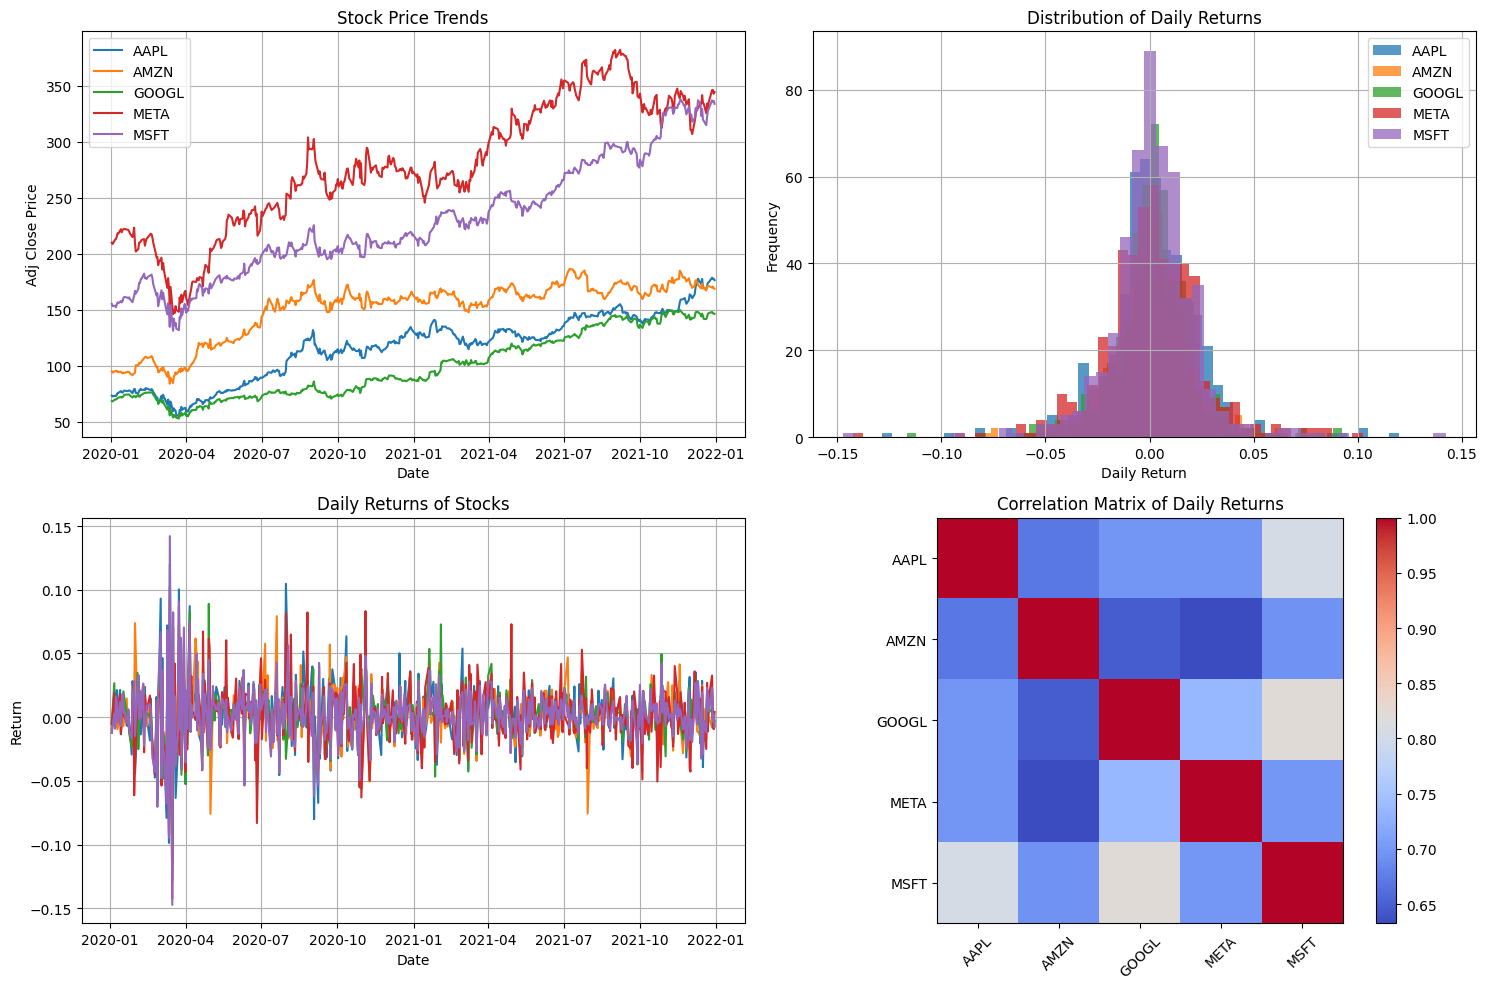

In [4]:

# 4 side-by-side plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), facecolor='white')

# Visualise stock price trends
axes[0, 0].plot(stock_data)
axes[0, 0].set_title('Stock Price Trends')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Adj Close Price')
axes[0, 0].grid(True)
axes[0, 0].legend(stock_data.columns)

# Visualise distribution of daily returns
for ticker in daily_returns.columns:
    axes[0, 1].hist(daily_returns[ticker], bins=50, alpha=0.75, label=ticker)
axes[0, 1].set_title('Distribution of Daily Returns')
axes[0, 1].set_xlabel('Daily Return')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Visualise daily returns of stocks
axes[1, 0].plot(daily_returns)
axes[1, 0].set_title('Daily Returns of Stocks')
axes[1, 0].set_ylabel('Return')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True)

# Calculate correlations between assets
correlation_matrix = daily_returns.corr()

# Visualise correlation matrix of daily returns
im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
fig.colorbar(im, ax=axes[1, 1])
axes[1, 1].grid(False)
axes[1, 1].set_xticks(range(len(correlation_matrix)))
axes[1, 1].set_xticklabels(correlation_matrix.columns, rotation=45)
axes[1, 1].set_yticks(range(len(correlation_matrix)))
axes[1, 1].set_yticklabels(correlation_matrix.columns)
axes[1, 1].set_title('Correlation Matrix of Daily Returns')

# Adjust spacing between plots
plt.tight_layout()

# Display the plots
plt.show()


**Plotting Asset Data**

The stock price visualisation plot showcases the historical stock prices for the five assets over the specified time frame. The $x$-axis represents time, while the $y$-axis indicates the stock price. The plot provides a clear view of the price trends and allows for easy comparison between the stock performances.

The histogram visualises the distribution of daily returns for the stocks. It offers insights into the frequency of certain return ranges, helping to understand the volatility and typical performance of each asset. The line chart also helps visualise the daily returns of the stocks

The heatmap displays the correlation coefficients between the daily returns of the stocks. A value close to $1$ indicates a strong positive correlation, while a value close to $-1$ shows a strong negative correlation. This visualisation aids in understanding how different assets move in relation to each other.


## **3.1** **Mean-Variance Optimisation ($MVO$)**

Before delving into the application of machine learning, it is essential to understand the fundamentals of portfolio optimisation. The following sections will provide an overview for some of the traditional portfolio optimisation methods, such as Mean-Variance Optimisation ($MVO$) and the Capital Asset Pricing Model ($CAPM$).

Mean-Variance Optimisation ($MVO$) is a classical portfolio optimisation technique that seeks to maximise the portfolio's expected return while minimising its variance or risk. There is always a trade-off between expected returns and risk, and our goal is aiming to achieve the most optimal balance. We will discuss the underlying assumptions and limitations of $MVO$.

The key principles of $MVO$ to remember are the risk and return trade-off - every increase in potential return comes with an increase in risk. $MVO$ uses this principle to find portfolios that offer the maximum expected return for a given level of risk. The second principle involves diversification, by combining assets that aren't perfectly correlated, $MVO$ will help in constructing portfolios that reduce unsystematic risk. 

Given a set of assets with known expected returns, the expected return of a portfolio is the weighted sum of the expected returns of the individual assets:

$$ E(R_p) = \sum_{i=1}^{N} w_{i} E(R_{i}). $$

$E(R_{p})$ and $E(R_{i})$ are the expected returns of the portfolio and asset $i$ respectively, and $w_{i}$ is the weight of asset $i$ in the portfolio. Note that there are a total of $N$ assets in the portfolio, and we require that the weights sum to $1$, that is $\sum_{i=1}^{N} w_{i} = 1$. We can compute the variance of the portfolio based on the variances of the individual assets, their weights, and correlation, $\rho_{ij}$ between them:

$$ \text{Var}(R_{p}) = \sum_{i=1}^{N} \sum_{j=1}^{N} w_{i} w_{j} \text{Cov}(E(R_{i}), E(R_{j})). $$

$ \sigma_{i} = \sqrt{\text{Var}(R_{i})} $ is the standard deviation of asset $i$ and $ -1 \leq \rho_{ij} \leq 1 $ is the correlation coefficient defined as, 
$ \rho_{ij} = \frac{\text{Cov}(r_{i}, r_{j})}{\sigma_{i} \sigma_{j}} = \frac{S_{r_{i}r_{j}}}{\sqrt{S_{r_{i}r_{i}} S_{r_{j}r_{j}}}}. $ This result follows just from using the definition of the product moment correlation coefficient ($PMCC$), where we use $r_{i} := E(R_{i})$ to compact notation.

## **3.2** **Assumptions and Limitations of $MVO$**

These are some of the assumptions made when using Mean-Variance Optimisation, these assumptions simplify our model - making it easier to use; however, this comes at the cost of
making the model unrealistic/impractical in real-world scenarios.

### **Assumptions of $MVO$**

- Investors are rational and avoid risk: investors aim to maximise their utility, which can be achieved with a high expected return and low portfolio risk.

- Investments are limited to a set of risky assets: $MVO$ doesn't consider the inclusion of risk-free assets.

- Returns are (jointly) normally distributed: this is often not the case in real financial markets, leading to potential underestimation of risk.

- Investors have access to the same information: all investors will estimate the expected returns, standard deviations, and correlation coefficients in the same way.
  
Here are a list of the limitations of $MVO$, these limitations are a direct result of some of the simplification/assumptions we have made when using the model. These limitations naturally suggests to us to use machine learning models which we will explore in the later sections.
  
### **Limitations of $MVO$**

- Estimation errors: $MVO$ is highly sensitive to changes in input parameters, which can lead to vastly different portfolios.

- Normal distribution assumption: financial returns are often not normally distributed. They can have fat tails, which means there's a higher probability of extreme returns.

- Static model: $MVO$ doesn't account for changes in the market over time.

Machine learning techniques can address some of these limitations. For example, they can handle non-linear relationships, adapt to changing market conditions, and account for non-normal distributions of returns.

## **3.3** **Optimum Weights**

Using the Sequential Least Squares Quadratic Programming ($SLSQP$) method, these are the optimal allocation of capital across the five stocks to maximise the Sharpe ratio:

In [5]:

# Compute log returns
log_returns = np.log(1 + weekly_returns)

# Expected returns give the avarage return for each stock
expected_returns = log_returns.mean()

# Covariance matrix captures how the returns of one stock vary with another
cov_matrix = log_returns.cov()

# Number of assets
num_assets = len(weekly_returns.columns)

# Define risk level
risk = 0.01

# Calculate risk-free rate
risk_free_rate = (1 + risk) ** (1/52) - 1

# Maximum allocation for any single asset
max_allocation = 1.00

# Set up the objective function (negative Sharpe ratio)
def objective(weights):
    # Calculate expected portfolio return
    portfolio_return = np.sum(expected_returns * weights) * 52

    # Calculate portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 52, weights)))

    # Return negative Sharpe ratio (because we want to maximise it)
    return - (portfolio_return - risk_free_rate) / portfolio_volatility

# Constraints - the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds for each asset: between 0 and max_allocation
bounds = tuple((0, max_allocation) for asset in range(num_assets))

# Initial weights - equal distribution across all assets
initial_weights = [1./len(expected_returns) for asset in expected_returns]

# Run the optimiser to get optimal asset weights,the optimiser maximises the Sharpe Ratio
solution = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimised asset weights from the solution
optimal_weights = solution.x

# Create a DataFrame with the stock ticker names and the associated weightings
portfolio_weights = pd.DataFrame({
    'Stock Ticker': stock_tickers,
    'Optimal Weight': optimal_weights
})

# Display the DataFrame
portfolio_weights


,Stock Ticker,Optimal Weight
0,AAPL,0.220675
1,GOOGL,0.049703
2,MSFT,0.347835
3,AMZN,0.000000
4,META,0.381787


Apple accounts for approximately ~$22.07\%$ of the portfolio. Where as Google makes up ~$4.97\%$ of the portfolio. $SLSQP$ allocates ~$34.78\%$ of the portfolio to Microsoft and ~$34.78\%$ to Meta (*Facebook*). This means, based on the data and optimisation objective - Amazon's optimal weight is ~$0.00\%$ meaning it's not ideal to hold Amazon in the portfolio to achieve the maximum Sharpe ratio.

These weights suggest that the model finds the most value (in terms of risk-adjusted returns) in allocating capital to Meta and Microsoft. Apple also gets a significant allocation, while google gets a smaller portion; and Amazon doesn't get any allocation under these parameters.

## **3.4** **Sharpe Ratio**

The Sharpe ratio is a measure used to understand the average return earned in excess of the risk-free rate per unit of volatility or total risk. It provides a tool to assess the 
risk-adjusted performance of an investment or a portfolio. The formula for the Sharpe ratio is:

$$ \text{Sharpe Ratio} = \frac{E(R_p) - R_f}{\sigma_{p}} $$

$E(R_p)$ is the expected return of the portfolio, $R_f$ is the risk-free rate, and $\sigma_{p} = \sqrt{\text{Var}(R_p)}$ is the standard deviation (volatility) of returns of the portfolio; representing its' total risk.

- A higher Sharpe ratio indicates a better risk-adjusted performance of the investment or portfolio. Essentially, for every unit of risk (volatility) taken, the investment returns a certain excess amount of return over the risk-free rate.

- A positive Sharpe ratio means the investment return is higher than the risk-free rate, whereas a negative Sharpe ratio indicates the investment return is below the risk-free rate.
		
- A Sharpe ratio of zero suggests that the investment has a return exactly equal to the risk-free rate.

For our purposes, the Sharpe ratio is used as a criterion in portfolio optimisation, where the goal is to maximise the Sharpe ratio, thereby seeking the portfolio with the best risk-adjusted return.

## **3.5** **Efficient Frontier**

The efficient frontier visualisation helps investors understand the risk-return trade-off and identify portfolios that maximise returns for a given risk level. When selecting portfolios, those on the efficient frontier curve are preferable, with the red-starred portfolio being the most optimal, and the green-starred being the safest in terms of risk-adjusted returns.

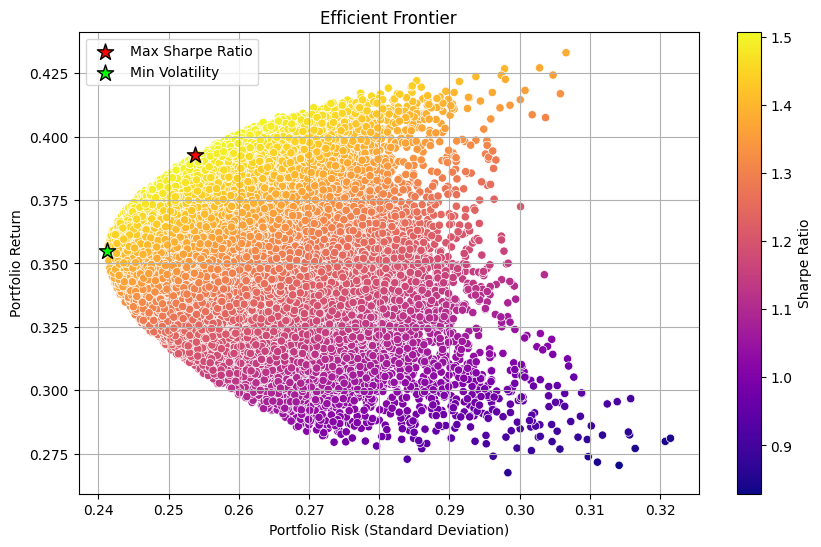

In [197]:

# Number of random portfolios to generate for our simulation
num_portfolios = 100000

# Placeholders for storing portfolio metrics (return, volatility, Sharpe ratio)
results = np.zeros((3, num_portfolios))

# Create an empty list to store portfolio weights
weights_list = []

# Simulate multiple portfolios and calculate metrics for each portfolio
for i in range(num_portfolios):
    # Randomly assign weights to assets
    weights = np.random.random(num_assets)

    # Normalise weights
    weights /= np.sum(weights)

    # Calculate expected portfolio return
    portfolio_return = np.sum(expected_returns  * weights) * 52

    # Calculate portfolio volatility (standard deviation)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 52, weights)))

    # Calculate Sharpe ratio: measures performance of investment compared to risk-free asset
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev

    # Store results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio

    # Append the weights to weights_list
    weights_list.append(weights)

# Extract portfolios with the highest Sharpe ratio and the lowest risk
return_sharpe_max = results[0, results[2].argmax()]
risk_sharpe_max = results[1, results[2].argmax()]
return_risk_min = results[0, results[1].argmin()]
risk_risk_min = results[1, results[1].argmin()]

# Plotting the efficient frontier
plt.figure(figsize=(10, 6), facecolor='white')
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', marker='o', alpha=1, edgecolors='w', linewidth=0.5)
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.grid(True)

# Highlight portfolios with the highest Sharpe ratio and the lowest risk
plt.scatter(risk_sharpe_max, return_sharpe_max, c='red', marker='*', s=150, edgecolors='black', label='Max Sharpe Ratio')
plt.scatter(risk_risk_min, return_risk_min, c='lime', marker='*', s=150, edgecolors='black', label='Min Volatility')
plt.legend(loc='upper left', fontsize='medium')

# Display the plot
plt.show()


**Efficient Frontier Scatter Plot**

Each point on the scatter plot represents a potential portfolio composed of the assets considered. The position of a point is determined by its risk (standard deviation on the $x$-axis) and expected return (on the $y$-axis).

The colour of each point corresponds to its Sharpe ratio, which measures the risk-adjusted return of the portfolio. A higher Sharpe ratio suggests a more favorable risk-to-reward trade-off. In this visualisation, the color gradient is shown using the 'plasma' colormap, with warmer colors indicating higher Sharpe ratios.

A red star marks the portfolio with the maximum Sharpe ratio. It's the most desirable portfolio because it offers the highest return for a given level of risk. This point is often referred to as the *tangency portfolio* since it's where the Capital Market Line, $CML$ (a line drawn from the risk-free rate tangent to the efficient frontier) touches the frontier.

A lime star represents the portfolio with the minimum volatility (or risk). It's the safest portfolio because it has the lowest standard deviation, and thus, the lowest risk.

The curve formed by the upper boundary of the scatter plot represents the efficient frontier. This boundary denotes the set of optimal portfolios that offer the highest expected return for a defined level of risk. Portfolios below this boundary are sub-optimal because they either provide less return for the same level of risk or have more risk for the same expected return.

## **3.6** **Optimised Portfolio Analysis** 

The table below gives asset allocations for portfolios corresponding to the maximum Sharpe ratio and minimum risk. The maximum Sharpe ratio portfolio aims to give the highest risk-adjusted return, and the minimum risk portfolio, as the name suggests, aims to mitigate risk.

In [31]:

# Convert weights_list to a numpy array
weights_arr = np.array(weights_list)

# Extract the weights for the portfolios with the maximum Sharpe ratio and minimum risk
weights_sharpe_max = weights_arr[results[2].argmax()]
weights_risk_min = weights_arr[results[1].argmin()]

# Construct weights DataFrame
weights_df = pd.DataFrame({
    'Stock Ticker': stock_tickers,
    'Weight (Max Sharpe Ratio)': weights_sharpe_max,
    'Weight (Min Risk)': weights_risk_min
})

# Display the DataFrame
weights_df


,Stock Ticker,Weight (Max Sharpe Ratio),Weight (Min Risk)
0,AAPL,0.214641,0.003440
1,GOOGL,0.025050,0.339532
2,MSFT,0.363010,0.350740
3,AMZN,0.000673,0.007854
4,META,0.396626,0.298435


As for the max Sharpe ratio portfolio, $META$ has the highest allocation of ~$39.66\%$, followed by $MSFT$ (~$36.3\%$) and then $AAPL$ (~$21.46\%$). $GOOGL$ and $AMZN$ on the other hand, have much lower allocations of ~$2.51\%$ and ~$0.07\%$ respectively.


For the min risk portfolio, $MSFT$ has the highest allocation at ~$35.07\%$, closely followed by $GOOGL$ (~$33.95\%$) and $META$ (~$29.84\%$). $AAPL$ and $AMZN$ have minimal allocations, at ~$0.34\%$ and ~$0.78\%$ respectively.

As you can see, the asset allocation between the two portfolios is quite different. $META$ is heavily favoured in the max Sharpe ratio portfolio, but has a reduced weight in the min risk portfolio. Conversely, $GOOGL$, which has a small presence in the max Sharpe ratio portfolio, has a significant weight in the min risk portfolio. $MSFT$ maintains a strong presence in both portfolios. $AMZN$ is minimally represented in both portfolios, suggesting that, according to the historical data and the constraints set in the $SLSQP$ optimisation process, it might not be contributing substantially to either maximising the Sharpe ratio or minimising the risk.

In [32]:

# Construct max Sharpe ratio / min risk DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Portfolio Return', 'Portfolio Risk', 'Sharpe Ratio'],
    'Max Sharpe Ratio': [return_sharpe_max, risk_sharpe_max, results[2].max()],
    'Min Risk': [return_risk_min, risk_risk_min, results[2][results[1].argmin()]]
})

# Displaying the DataFrame
metrics_df


,Metric,Max Sharpe Ratio,Min Risk
0,Portfolio Return,0.396189,0.353511
1,Portfolio Risk,0.256094,0.241258
2,Sharpe Ratio,1.546296,1.464490


The max Sharpe ratio portfolio has a Sharpe ratio of ~$1.5463$, the portfolio return is ~$39.62\%$ per annum, while the risk (standard deviation) is ~$25.61\%$ per annum. Comparing this with the min risk portfolio which has a risk of ~$24.13\%$ per annum, a Sharpe ratio of ~$1.4645$ - just ~$0.0818$ difference, and a return per annum of ~$35.35\%$. It is clear that the max Sharpe ratio portfolio offers a higher expected return. This is consistent with the risk-return trade-off; generally, portfolios with higher expected returns are also expected to exhibit higher volatility (risk). 

Similarly, the max Sharpe ratio portfolio has a slightly higher Sharpe ratio than the min risk portfolio, suggesting that it provides a better risk-adjusted return. Lastly, for risk, as the name suggests, the min risk portfolio has a lower risk (volatility) compared to the max Sharpe ratio portfolio, that said the difference in risk between the portfolios is not that substantial with just a difference of ~$1.48\%$.

In summary, if maximising returns for a given level of risk is the primary objective, then the max Sharpe ratio portfolio would be preferred. However, if minimising risk is more crucial, even at the expense of potentially higher returns, then the min risk portfolio would be more suitable.

## 4.1 **Capital Asset Pricing Model (CAPM)**

The Capital Asset Pricing Model ($CAPM$) is a fundamental tool in finance that relates an asset's expected return to its systematic risk. We will explore the concepts of beta, the security market line ($SML$), and the risk-free rate in the context of $CAPM$. The $CAPM$ uses the formula,

$$ E(R_i) = R_f + {\beta}_i (E(R_m) - R_f), $$ 

where $E(R_m)$ and $E(R_i)$ are the expected return of the market/asset $i$ respectively, $R_f$ is the risk-free rate, ${\beta}_i$ is the beta of asset $i$ - the volatility in relation to the market. Also, note that: 

$${\beta}_i = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}, $$ 

where for discrete random variables $X$ and $Y$ with $X_{i}$ and $Y_{i}$ denoting the $i^{th}$ sample of $X$ and $Y$ respectively, $\text{Var}(X) = \frac{S_{X_{i}X_{i}}}{N}$ and $\text{Cov}(X,Y) = \frac{S_{X_{i}Y_{i}}}{N}$. Recall that $S_{X_{i}Y_{i}} = \sum_{i=0}^{N} X_{i}Y_{i} - N \bar{X_{i}} \bar{Y_{i}}$. Thus $\beta_{i} = \frac{S_{R_{i} R_{m}}}{S_{R_{m} R_{m}}}$, which is just the gradient of the regression line $y$ on $x$. We can use $RSS$ (or some other metric) to calculate how closely the data fits a linear model.

## **4.2** **Assumptions and Limitations of $CAPM$**

Here are some of the assumptions made when using the Capital Asset Pricing Model, these assumptions simplify our model - making it easier to use; however, this comes at the cost of making the model unrealistic/impractical in real-world scenarios.

### **Assumptions of $CAPM$**

- Investors hold diversified portfolios: this implies that investors will only require a return for the systematic risk of their investments.

- No transaction costs: investors can buy and sell securities without incurring any costs, which isn't the case in real-world scenarios.

- Investors can lend and borrow at the risk-free rate: this is often not feasible in real markets.
  
- All investors have the same expectations: investors are assumed to agree on the expected returns, volatilities, and correlations of all assets.

Here are a list of the limitations of the Capital Asset Pricing Model, these limitations are a direct result of some of the simplification/assumptions we have made when using the model. These limitations naturally suggests to us to use machine learning models which we will explore in the later sections.
  
### **Limitations of $CAPM$**

- Beta's predictive power: the beta of $CAPM$, which measures systematic risk, may not always be a complete measure of risk.

- Market portfolio: the true market portfolio cannot be observed in reality, so proxies like the $ S\&P ~ 500 $ are used, which might not capture the entire market.
  
- Static nature: $CAPM$ is a single-period model and doesn't capture changes over multiple periods.

Again, machine learning can help in capturing dynamic relationships, understanding non-linear patterns, and accounting for multiple factors that might affect stock returns beyond just the market return.

## **4.3** **Security Market Line ($SML$)**

In this plot we've taken market data from each of the assets and the $S\&P ~ 500$ which acts as the market benchmark. By taking the risk free rate at $1\%$, calculating the expected stock return and 
expected market return, we can use this to find the market risk premium which is the slope of the $SML$ (red line) using the $CAPM$ formula, *market_risk_premium = expected_market_return - risk_free_rate*. Multiplying the market risk premium by $\beta_{i}$ and adding the risk free rate will give us the expected return for each of the assets (see below).

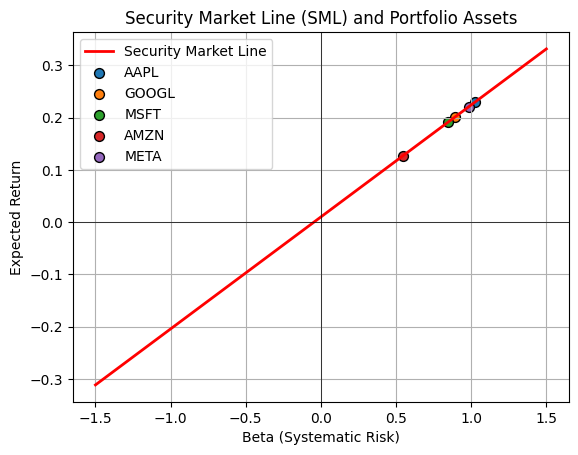

In [196]:

# Compute expected market return
expected_market_return = weekly_market.mean() * 52 

# Define the risk-free rate (1% annual rate)
risk_free_rate = 0.01 

# Define the excess return from the market (market return minus risk-free rate)
market_risk_premium = expected_market_return - risk_free_rate

# Set up a range of possible beta values for plotting the SML (consider beta values from -1.5 to 1.5)
beta_values = np.linspace(-1.5, 1.5, 200)

# Calculate the corresponding expected returns for each beta value according to the SML
sml_returns = risk_free_rate + beta_values * market_risk_premium

# Initialise a dictionary to store the beta and expected return for each asset
asset_data = {
    'Asset': [], 
    'Beta': [], 
    'Expected Return': []
}

# Plot the Security Market Line (SML) using the beta values and corresponding expected returns
plt.plot(beta_values, sml_returns, label='Security Market Line', color='red', linewidth=2)

# Highlight assets position on the SML chart, this shows where asset stands in terms of its risk (beta) and expected return
for stock_symbol in stock_tickers:
    stock_returns = weekly_returns[stock_symbol]

    # Align data (in case there are missing dates in one of them)
    aligned_data = pd.concat([stock_returns, weekly_market], axis=1).dropna()
    aligned_stock_returns = aligned_data.iloc[:, 0]
    aligned_market_returns = aligned_data.iloc[:, 1]
    
    # Compute the beta for the stock
    beta = aligned_stock_returns.cov(aligned_market_returns) / aligned_market_returns.var()
    
    # Use CAPM to compute expected stock return
    expected_stock_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)

    # Append the results to the dictionary
    asset_data['Asset'].append(stock_symbol)
    asset_data['Beta'].append(beta)
    asset_data['Expected Return'].append(expected_stock_return)
    
    # Plot the stock on the SML chart
    plt.scatter(beta, expected_stock_return, s=50, edgecolor='black', marker='o', label=f'{stock_symbol}')

# Add labels, title, and grid
plt.title('Security Market Line (SML) and Portfolio Assets')
plt.xlabel('Beta (Systematic Risk)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()

# Display the plot
plt.show()


**Security Market Line (SML) Graph**

The Security Market Line ($SML$) graph visually represents the relationship between the expected return of an asset and its systematic risk (beta). On this graph, the $y$-axis represents the expected return of an asset, while the $x$-axis represents its beta. The slope of the $SML$ is determined by the market risk premium. Assets that plot on the $SML$ are considered fairly priced. If an asset plots above the $SML$, it indicates that it provides a higher return for its level of risk than the market portfolio, suggesting it might be undervalued. Conversely, assets below the $SML$ might be overvalued, as they offer lower returns for their level of risk.

## **4.4** **Asset Beta and Expected Returns**

In [9]:

# Convert the dictionary to a pandas DataFrame
beta_data = pd.DataFrame(asset_data)

# Display the DataFrame
beta_data


,Asset,Beta,Expected Return
0,AAPL,1.026422,0.229926
1,GOOGL,0.891786,0.201078
2,MSFT,0.848228,0.191745
3,AMZN,0.547861,0.127387
4,META,0.985201,0.221094


A beta value greater than $1$ suggests that the asset's returns are more volatile than the market's. In Apple's case, its beta, ~$1.0264$, suggests that it's roughly ~$2.64\%$ more volatile than the market. The $CAPM$ suggests that, given Apple's beta and the prevailing market conditions, an investor should expect a return of approximately ~$22.99\%$ for holding Apple, given the risk associated.

Google's beta (~$0.8918$) suggests that it's about ~$10.82\%$ less volatile than the market. For the risk associated with holding Google (which is slightly less than the market risk), an investor might expect a return of ~$20.11\%$.

Microsoft is about ~$15.18\%$ less volatile than the market having a beta of ~$0.8482$. Given this beta value, we'd expect a return of ~$19.17\%$ for holding it.

Amazon's low beta ~$0.5479$ suggests it's approximately ~$45.21\%$ less volatile than the market. This might seem surprising given Amazon's growth, but it could be influenced by time frame or some of the assumptions/limitations of $CAPM$, we have discussed some of these drawbacks earlier in the section. Amazon's expected return is the lowest among the assets (~$12.74\%$), reflecting its lower beta.

Meta's beta value of ~$0.9852$ suggests its returns are roughly in line with the market, being just ~$1.48\%$ less volatile, with expected returns similar to Apple of ~$22.11\%$.

Some of these expected returns are unreasonably high, and comparing with the actual historical returns for each asset we can see that the models predictions are not very accurate. A possible reason for high expected returns is explained in the limitations/assumptions section.

## **5.1** **Introduction to Machine Learning in Portfolio Optimisation**

Portfolio optimisation has traditionally relied on mathematical models and techniques, such as the Capital Asset Pricing Model and Mean-Variance Optimisation, to determine the best allocation of assets in a portfolio. These traditional methods are based on certain assumptions about market behavior, which may not always hold true. This is where machine learning offers a fresh perspective.

Machine learning, with its ability to model and predict complex, non-linear relationships, provides tools to capture patterns in data that might be overlooked by traditional models. By analysing vast amounts of historical data, machine learning algorithms can identify intricate relationships between assets, potentially leading to better portfolio performance.

However, like all models, machine learning-based approaches have their limitations. They require large datasets to train on, can sometimes be opaque or hard to interpret (a challenge known as the "*black box*" problem), and are sensitive to the quality of the input data.

## **5.2** **Overview of Machine Learning Algorithms**

The three main machine learning models we'll be taking a look at are:

- Decision Trees: they map out decisions and their possible consequences. In portfolio management, they can be used to decide on asset allocations based on certain criteria.

- Random Forests: an ensemble of Decision Trees, often trained with the "bagging" method (bootstrap aggregating). They can reduce overfitting compared to a single Decision Tree and give better accuracy.

- Neural Networks: comprise layers of interconnected nodes or "neurons". They are especially good at capturing non-linear relationships in data, which can be beneficial for predicting stock prices. (This will be in the updated notebook, see Additional).

To evaluate and compare the potential performance of different asset combinations, we'll simulate multiple portfolios with random asset allocations. This simulation will give us insights into the possible returns and volatilities we can expect from different portfolio structures. We'll simulate portfolios using historical data, and for each portfolio, we'll calculate its expected return and volatility based on the random asset weights. This will provide further insight into the risk-reward trade-off for our simulations.

In [10]:

# Splitting the daily_returns data into training (historical) and testing (future) sets (80% train, 20% test)
train_size = int(0.8 * len(daily_returns))
train_returns = daily_returns[:train_size]
test_returns = daily_returns[train_size:]

# Number of portfolios to simulate
num_portfolios = 10000

# Initialising arrays to store portfolio metrics
weights_arr = np.zeros((num_portfolios, len(train_returns.columns)))
returns_arr = np.zeros(num_portfolios)
volatility_arr = np.zeros(num_portfolios)

# Calculating the log of returns for the historical data
log_returns_train = np.log(1 + train_returns)

# Simulating portfolios using the historical data
for i in range(num_portfolios):
    weights = np.random.random(len(train_returns.columns))
    weights /= np.sum(weights)
    returns_arr[i] = np.sum(log_returns_train.mean() * weights) * 252
    volatility_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns_train.cov() * 252, weights)))
    weights_arr[i, :] = weights

# Creating a DataFrame to store simulated portfolio metrics
portfolios_train = pd.DataFrame({
    'Returns': returns_arr, 
    'Volatility': volatility_arr
})

# Adding asset weights to the DataFrame
for i, ticker in enumerate(train_returns.columns):
    portfolios_train[ticker + " Weight"] = weights_arr[:, i]

# Setting up features and target variable
features = ['Volatility'] + [ticker + " Weight" for ticker in train_returns.columns]
target = 'Returns'

X = portfolios_train[features]
y = portfolios_train[target]

# Splitting the simulated portfolios into training and validation subsets
train_size_simulated = int(0.8 * num_portfolios)
X_train, X_val = X.iloc[:train_size_simulated], X.iloc[train_size_simulated:]
y_train, y_val = y.iloc[:train_size_simulated], y.iloc[train_size_simulated:]


## **5.3** **Decision Trees**

Decision Trees split the data into subsets based on certain decision rules - mapping out these decisions and their possible consequences. They are intuitive and easy to visualise but can sometimes overfit to the training data. A Decision Tree can be employed to predict the future return of a stock or a portfolio based on historical data. The tree makes decisions based on various factors, such as past returns, trading volumes, and other relevant financial indicators.

For our portfolio optimisation task, it's looking at relationships between asset weights, volatility, and returns to predict portfolio returns. The metrics we've computed provide insights into how well the Decision Tree has learned these relationships:

- $MAE$ (Mean Absolute Error): this metric tells us, on average, how much our predictions deviate from the actual returns. A lower $MAE$ is better.
  
- $RMSE$ (Root Mean Squared Error): this metric gives more weight to larger errors, making it more sensitive to outliers than $MAE$. A lower $RMSE$ indicates a better fit to the data. Note $MSE$ is just the (positive) square root of the $RMSE$. We will explore $MSE$ later.
  
- $R$-squared: represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A value closer to $1$ indicates that the model explains a higher proportion of the variance.

In [11]:

# Define the hyperparameters and their possible values
param_grid = {
    # Maximum depth of the tree, 'None' means unlimited depth
    'max_depth': [3, 5, 7, 10, None],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
    # Criterion to measure the quality of a split
    'criterion': ['squared_error', 'absolute_error']
}

# Initialise the DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=7)

# Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialise GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(dt, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model from the grid search
best_params = grid_search.best_params_
decision_tree_model = grid_search.best_estimator_

# Use the best model from GridSearchCV to predict portfolio returns on the training and validation set
y_val_pred_dt = decision_tree_model.predict(X_val)
y_train_pred_dt = decision_tree_model.predict(X_train)

# Calculate Mean Absolute Error (MAE)
mae_dt = mean_absolute_error(y_val, y_val_pred_dt)

# Calculate R-squared (R2)
r2_dt = r2_score(y_val, y_val_pred_dt)

# Calculate Mean Squared Error (MSE)
mse_dt = mean_squared_error(y_val, y_val_pred_dt)

# Calculate Root Mean Squared Error (RMSE)
rmse_dt = np.sqrt(mse_dt)


The process of hyperparameter tuning ensures that you're not just fitting your model to the training data but that it can also generalise well to unseen data. The hyperparameters are  set prior to training a machine learning model. They are not learned from the data but can significantly impact model performance. For example, certain hyperparameters can affect the speed and efficiency of training and can influence the complexity of the model leading to optimal model complexity. 

In Decision Trees, the depth of the tree (max_depth) can determine how well the model fits to the data. Too deep, and it may overfit; too shallow, and it may underfit. Some hyperparameters introduce regularisation (like the min_samples_leaf in Decision Trees), which can prevent overfitting by adding constraints to the model.

$k$-fold cross-validation involves partitioning the original training dataset into $k$ equal subsets or folds. Then, a model is trained using $k−1$ of the folds and validated on the remaining fold. This process is repeated $k$ times, with each fold serving as the validation set exactly once. The performance metric is then averaged over all $k$ trials to provide a more stable estimate of model performance. By integrating $k$-fold cross-validation in our Decision Tree training process, we ensure a more robust assessment of the model's capability.

In grid search, for each hyperparameter, we specify a range of values. The algorithm then systematically trains the model for every combination of hyperparameters. This ensures that we explore a wide range of configurations to find the best one.

To summarise, for each combination of hyperparameters, $k$-fold cross-validation trains the model on different subsets (or "folds") of the data and validates it on the remaining data. This process is repeated $k$ times. This provides a more stable and robust estimate of the model's performance, ensuring that the chosen hyperparameters generalise well across different subsets of data.

In [12]:

# Create a DataFrame for Decision Tree metrics
metrics_dt = pd.DataFrame({
    'Model': ['Decision Tree'],
    'MAE': [mae_dt],
    'RMSE': [rmse_dt],
    'R-squared': [r2_dt],
    'MSE': [mse_dt]
})

metrics_dt


,Model,MAE,RMSE,R-squared,MSE
0,Decision Tree,0.001363,0.001804,0.967676,0.000003


This is an explaination for the physical interpretations for each of the metrics calculated using the Decision Tree machine learning algorithm:

- $MAE$ (Mean Absolute Error): ~$1.36 \times 10^{-3}$ - this metric tells us that, on average, the model's predictions are off by approximately ~$1.36 \times 10^{-3}$. Given that this is a small value, it indicates the models predictions are quite close to the actual returns.

- $RMSE$ (Root Mean Squared Error): ~$1.80 \times 10^{-3}$ - $RMSE$ gives more weight to larger errors. This means if you have more outliers or predictions that were way off, this value will increase. The $RMSE$ being slightly higher than the $MAE$ suggests that there might be a few predictions where the model didn't perform as well. Still, given the small value, the model is doing a good job overall.

- $R$-squared: ~$9.68 \times 10^{-1}$ - this is a proportion between  $0 \leq R^{2} \leq 1$, and it tells you the percentage of the variance in the dependent variable (portfolio returns) that the independent variables explain. An $R$-squared value of ~$9.68 \times 10^{-1}$ means that approximately $96.8\%$ of the variation in portfolio returns can be explained by the model. This is a strong $R$-squared value, indicating a high level of predictive power.

- $MSE$ (Mean Squared Error): ~$3.00 \times 10^{-6}$ - this metric represents the average squared difference between the observed actual out-turn values and the values predicted by the model. The small $MSE$ value indicates that the model's predicitve capabilities are fairly accurate.

## **5.4** **Random Forest**

Random Forests are an ensemble learning method that builds upon the Decision Tree algorithm. Instead of relying on a single Decision Tree, Random Forests consist of multiple Decision Trees. A Random Forest uses a collection (or "forest") of Decision Trees to make predictions, each tree is trained on a random subset of the data with replacement and makes its own predictions. This technique called bootstrapping, and means that some samples may be used multiple times in a single tree, while others may not be used at all. The Random Forest then aggregates these predictions to produce a final result which is typically an average of the predictions from all trees in the forest. This ensemble approach generally improves performance and reduces overfitting providing a more robust model compared to a single Decision Tree.

The benefits of using Random Forests in portfolio optimisation include the ability to capture complex, non-linear relationships between assets, as well as providing a measure of feature importance. This can be particularly useful in identifying which financial indicators or asset relationships are most influential in determining portfolio returns.

As with the Decision Tree model, we will evaluate the Random Forest's performance using the following metrics:

- $MAE$: indicates the average error of the Random Forest model's predictions. Comparing with the Decision Tree's $MAE$ can give insights into the benefits of the ensemble approach.
 
- $RMSE$: helps understand the error distribution and the impact of outliers on the Random Forest model's predictions. (We will cover $MSE$ later in the section).

- $R$-squared: a higher $R$-squared value would suggest that the ensemble of trees in the Random Forest can explain more variance in the portfolio returns.

In [13]:

# Define the hyperparameters and their possible values for random forest
param_dist_rf = {
    # Number of trees in the forest
    'n_estimators': [50, 100, 150],
    # Maximum depth of the tree, 'None' means unlimited depth
    'max_depth': [3, 5, 7, 10, 15, None],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
    # Method for sampling data points (with or without replacement)
    'bootstrap': [True, False],
    # Criterion to measure the quality of a split
    'criterion': ['squared_error', 'absolute_error']
}

# Initialise the RandomForestRegressor
rf = RandomForestRegressor(random_state=7)

# Initialise TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialise RandomizedSearchCV with 5-fold cross-validation for random forest (k-fold cross-validation)
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=100, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=7)

# Fit the RandomizedSearchCV object to the data
random_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and model from the random search for random forest
best_params_rf = random_search_rf.best_params_
random_forest_model = random_search_rf.best_estimator_

# Use the best model from RandomizedSearchCV to predict portfolio returns on the training and validation set
y_train_pred_rf = random_forest_model.predict(X_train)
y_val_pred_rf = random_forest_model.predict(X_val)

# Calculate Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)

# Calculate R-squared (R2)
r2_rf = r2_score(y_val, y_val_pred_rf)

# Calculate Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_val, y_val_pred_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_rf = np.sqrt(mse_rf)


RandomizedSearchCV is used for hyperparameter tuning, this is different from GridSearchCV which was used in the Decision Tree model. The key difference being, traditional grid search methods evaluate every possible combination of hyperparameters, which can be computationally expensive. RandomizedSearchCV, on the other hand, samples a fixed number of hyperparameter combinations from the specified distributions. This approach is faster and can lead to better results, especially when the number of hyperparameters is large (as is the case).

In [14]:

# Create a DataFrame for Random Forest metrics
metrics_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'MAE': [mae_rf],
    'RMSE': [rmse_rf],
    'R-squared': [r2_rf],
    'MSE': [mse_rf]
})

metrics_rf


,Model,MAE,RMSE,R-squared,MSE
0,Random Forest,0.000536,0.000763,0.99422,5.820780e-07


This is an explaination for the physical interpretations for each of the metrics calculated using the Random Forest machine learning algorithm:

- $MAE$ (Mean Absolute Error): ~$5.36 \times 10^{-4}$ - the $MAE$ for the Random Forest model is approximately ~$5.36 \times 10^{-4}$. This metric conveys that, on average, the model's predictions deviate by about ~$5.36 \times 10^{-4}$ from the actual values. Given the diminutive nature of this value, it suggests that the Random Forest model's predictions are more precise compared to the Decision Tree model, emphasising its heightened accuracy in forecasting returns.

- $RMSE$ (Root Mean Squared Error): ~$7.63 \times 10^{-4}$ - the $RMSE$ value is approximately ~$7.63 \times 10^{-4}$. Like with the Decision Tree, the $RMSE$ metric prioritises larger errors more. The fact that this value is slightly larger than the $MAE$, though still quite small, indicates there might be occasional predictions where the model deviated a bit more. However, in general, the model's performance is quite good.

- $R$-squared: ~$9.94 \times 10^{-1}$ - again, this metric represents the proportion of variance in the dependent variable that can be attributed to the independent variables. An $R$-squared value of ~$9.94 \times 10^{-1}$ denotes that around $99.4\%$ of the variation in portfolio returns is elucidated by the model. This is a stronger $R$-squared value than the Decision Tree, showcasing the Random Forest's superior predictive prowess.

- $MSE$ (Mean Squared Error): ~$5.82 \times 10^{-7}$ - again, the $MSE$ indicates the average squared discrepancy between the observed actual outcomes and the values the model predicted. For the Random Forest, this value is about ~$5.82 \times 10^{-7}$, which is significantly lower than that of the Decision Tree. This underlines the Random Forest model's enhanced precision and suggests that the model has a strong capacity to predict portfolio returns accurately.

In summary, based on the provided metrics, the Random Forest model *appears* to have a stronger predictive capability than the Decision Tree, with higher accuracy and precision in its predictions, we'll explore this further in the next section. 

## **6.1** **Machine Learning Models Evaluation**

In [15]:

# Create a DataFrame for Random Forest and Decision Tree metrics
metrics = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'MAE': [mae_dt, mae_rf],
    'RMSE': [rmse_dt, rmse_rf],
    'R-squared': [r2_dt, r2_rf],
    'MSE': [mse_dt, mse_rf]
})

metrics


,Model,MAE,RMSE,R-squared,MSE
0,Decision Tree,0.001363,0.001804,0.967676,3.254927e-06
1,Random Forest,0.000536,0.000763,0.994220,5.820780e-07


The Random Forest model has a lower $MAE$ compared to Decision Tree, suggesting it makes, on average, smaller prediction errors compared to the Decision Tree model. Again, the Random Forest model has a lower $RMSE$, indicating it has fewer large prediction errors compared to the Decision Tree model. The $R^{2}$ value, often called the *coefficient of determination*, is larger for the Random Forest model, meaning it can explain a larger portion of the variance in the returns compared to the Decision Tree model. Lastly, Random Forest outperforms the Decision Tree model with a significantly lower $MSE$ indicating better predictive accuracy. Based on these metrics and the rationale behind each of them, it is clear that the Random Forest model consistently outperforms the Decision Tree model.

However, it's essential to consider other factors like model interpretability, training time, and computational cost. While Random Forests might give better predictions, Decision Trees are simpler and more interpretable.

In summary, the Random Forest model, which utilises an ensemble of Decision Trees and aggregates their predictions, offers a more accurate and reliable prediction for portfolio returns in this context. In the following sections, we will evaluate the performance of the $ML$ models by comparing the predicted against actual returns data.

## **6.2** **Training Data Analysis**

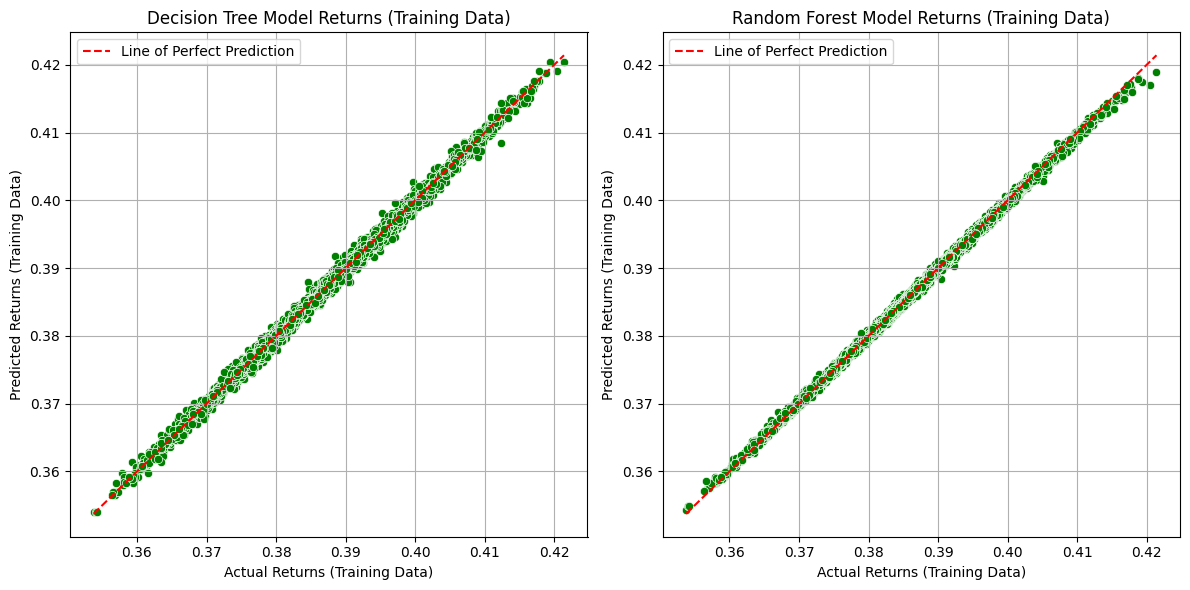

In [194]:

# Setup the plots
plt.figure(figsize=(12, 6))

# Scatter plot for training data for Decision Tree
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred_dt, alpha=1, marker='o', color='green')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label="Line of Perfect Prediction")
plt.xlabel('Actual Returns (Training Data)')
plt.ylabel('Predicted Returns (Training Data)')
plt.title('Decision Tree Model Returns (Training Data)')
plt.legend()
plt.grid(True)

# Scatter plot for training data for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train, y=y_train_pred_rf, alpha=1, marker='o', color='green')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label="Line of Perfect Prediction")
plt.xlabel('Actual Returns (Training Data)')
plt.ylabel('Predicted Returns (Training Data)')
plt.title('Random Forest Model Returns (Training Data)')
plt.legend()
plt.grid(True)

# Display scatter plots
plt.tight_layout()
plt.show()


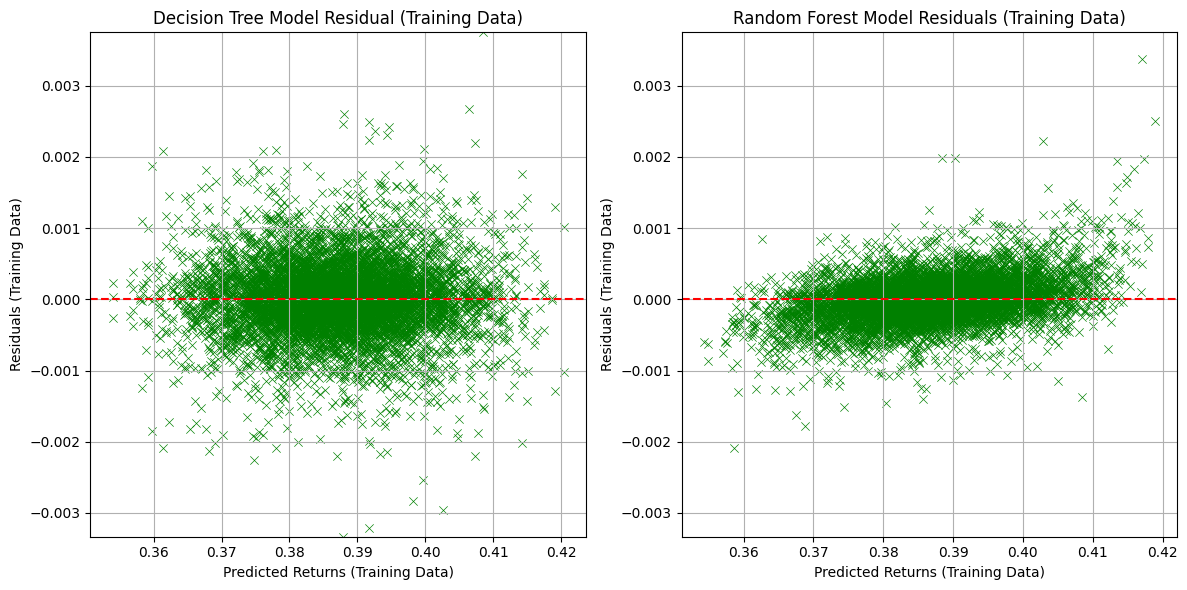

In [199]:

# Calculate residuals for training data
dt_residuals_train = y_train - y_train_pred_dt
rf_residuals_train = y_train - y_train_pred_rf

# Calculate the overall minimum and maximum residuals for both models
train_overall_min_residual = min(dt_residuals_train.min(), rf_residuals_train.min())
train_overall_max_residual = max(dt_residuals_train.max(), rf_residuals_train.max())

# Setup the plots
plt.figure(figsize=(12, 6))

# Residual plot for training data for Decision Tree
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_pred_dt, y=dt_residuals_train, alpha=1, marker='x', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Returns (Training Data)')
plt.ylabel('Residuals (Training Data)')
plt.title('Decision Tree Model Residual (Training Data)')
plt.ylim(train_overall_min_residual, train_overall_max_residual)  # Set the y-axis limits
plt.grid(True)

# Residual plot for training data for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train_pred_rf, y=rf_residuals_train, alpha=1, marker='x', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Returns (Training Data)')
plt.ylabel('Residuals (Training Data)')
plt.title('Random Forest Model Residuals (Training Data)')
plt.ylim(train_overall_min_residual, train_overall_max_residual)  # Set the y-axis limits
plt.grid(True)

# Display scatter plots
plt.tight_layout()
plt.show()


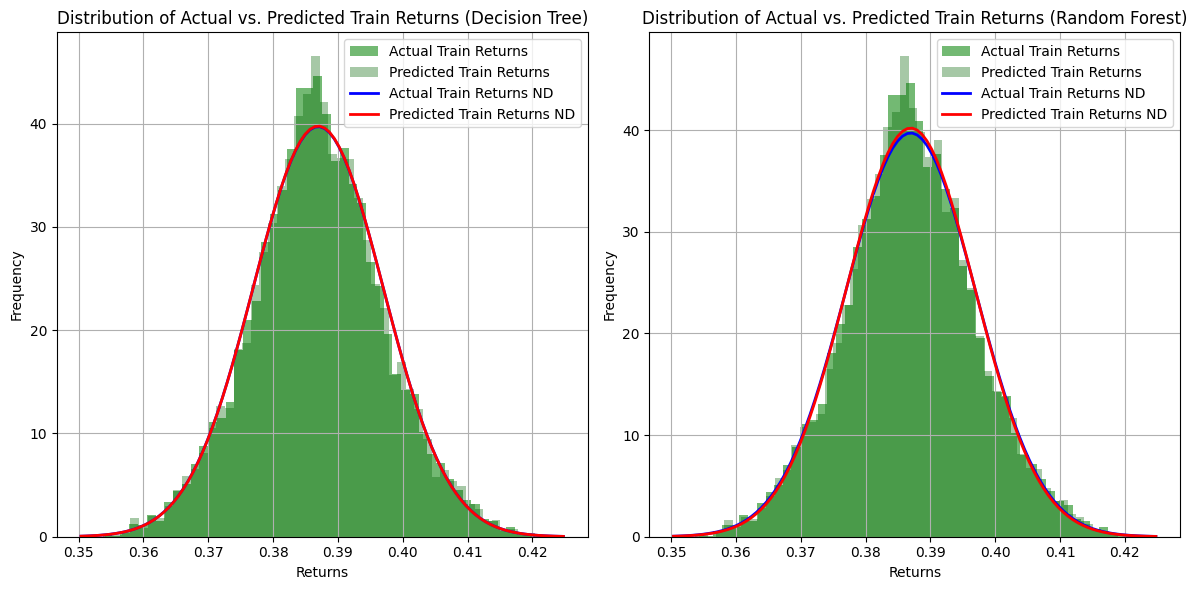

In [206]:

# Setup the plots
plt.figure(figsize=(12, 6))

# Histogram plot for training data for Decision Tree
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50, alpha=0.55, label='Actual Train Returns', color='green', density=True)
plt.hist(y_train_pred_dt, bins=50, alpha=0.35, label='Predicted Train Returns', color='darkgreen', density=True)
plt.title('Distribution of Actual vs. Predicted Train Returns (Decision Tree)')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Overlay normal distribution curve for training data for Decision Tree
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_actual = norm.pdf(x, np.mean(y_train), np.std(y_train))
p_pred = norm.pdf(x, np.mean(y_train_pred_dt), np.std(y_train_pred_dt))
plt.plot(x, p_actual, 'b', linewidth=2, label="Actual Train Returns ND")
plt.plot(x, p_pred, 'r', linewidth=2, label="Predicted Train Returns ND")

plt.legend()
plt.grid(True)

# Histograms plot for training data for Random Forest
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=50, alpha=0.55, label='Actual Train Returns', color='green', density=True)
plt.hist(y_train_pred_rf, bins=50, alpha=0.35, label='Predicted Train Returns', color='darkgreen', density=True)
plt.title('Distribution of Actual vs. Predicted Train Returns (Random Forest)')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Overlay normal distribution curve for training data for Random Forest
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_actual = norm.pdf(x, np.mean(y_train), np.std(y_train))
p_pred = norm.pdf(x, np.mean(y_train_pred_rf), np.std(y_train_pred_rf))
plt.plot(x, p_actual, 'b', linewidth=2, label="Actual Train Returns ND")
plt.plot(x, p_pred, 'r', linewidth=2, label="Predicted Train Returns ND")

plt.legend()
plt.grid(True)

# Display histogram plots
plt.tight_layout()
plt.show()


## **6.3** **Validation Set Analysis**

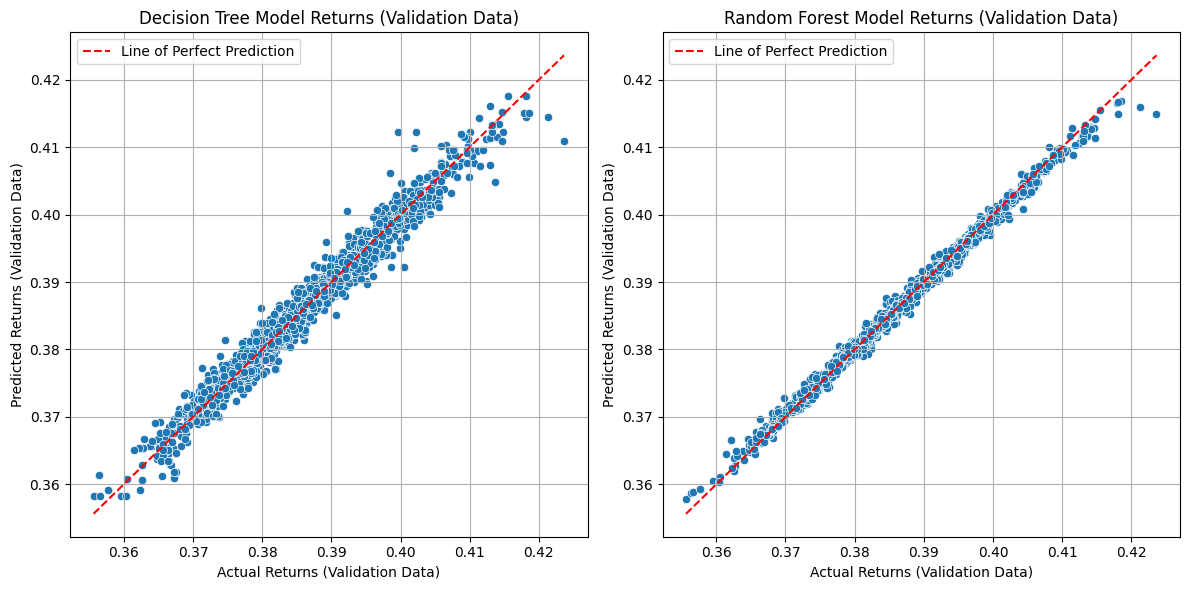

In [193]:

# Setup the plots
plt.figure(figsize=(12, 6))

# Scatter plot for validation data for Decision Tree
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val, y=y_val_pred_dt, alpha=1, marker='o')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="Line of Perfect Prediction")
plt.xlabel('Actual Returns (Validation Data)')
plt.ylabel('Predicted Returns (Validation Data)')
plt.title('Decision Tree Model Returns (Validation Data)')
plt.legend()
plt.grid(True)

# Scatter plot for validation data for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val, y=y_val_pred_rf, alpha=1, marker='o')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="Line of Perfect Prediction")
plt.xlabel('Actual Returns (Validation Data)')
plt.ylabel('Predicted Returns (Validation Data)')
plt.title('Random Forest Model Returns (Validation Data)')
plt.legend()
plt.grid(True)

# Display scatter plots
plt.tight_layout()
plt.show()


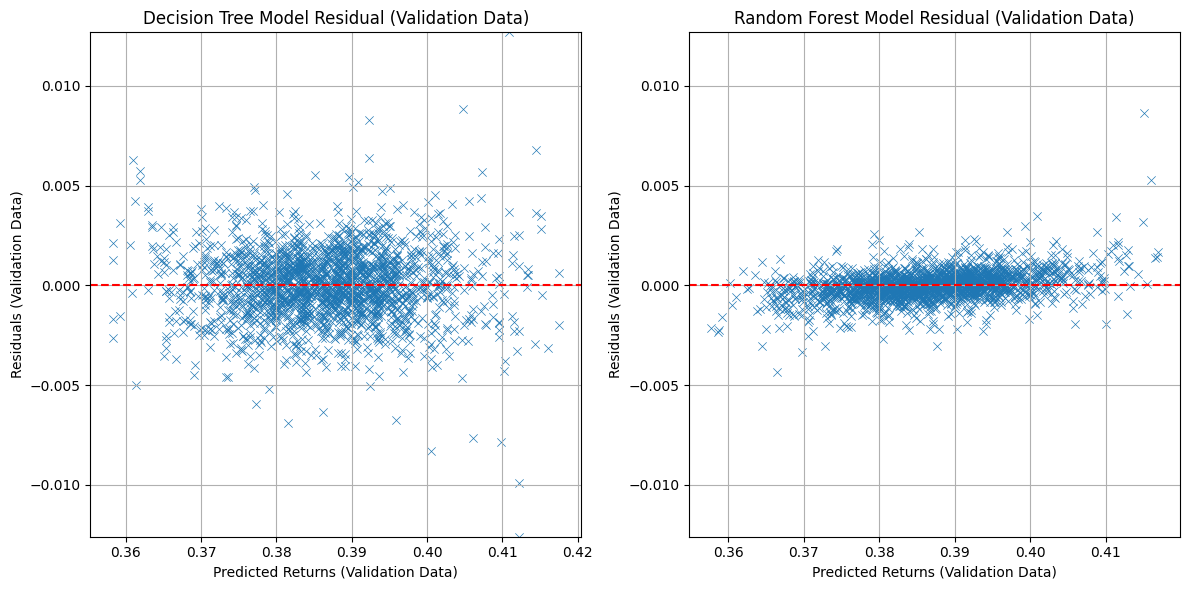

In [200]:

# Calculate residuals for validation data
dt_residuals_val = y_val - y_val_pred_dt
rf_residuals_val = y_val - y_val_pred_rf

# Calculate the overall minimum and maximum residuals for both models
val_overall_min_residual = min(dt_residuals_val.min(), rf_residuals_val.min())
val_overall_max_residual = max(dt_residuals_val.max(), rf_residuals_val.max())

# Setup the plots
plt.figure(figsize=(12, 6))

# Residual plot for validation data for Decision Tree
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val_pred_dt, y=dt_residuals_val, alpha=1, marker='x')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Returns (Validation Data)')
plt.ylabel('Residuals (Validation Data)')
plt.title('Decision Tree Model Residual (Validation Data)')
plt.ylim(val_overall_min_residual, val_overall_max_residual)  # Set the y-axis limits
plt.grid(True)

# Residual plot for validation data for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val_pred_rf, y=rf_residuals_val, alpha=1, marker='x')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Returns (Validation Data)')
plt.ylabel('Residuals (Validation Data)')
plt.title('Random Forest Model Residual (Validation Data)')
plt.ylim(val_overall_min_residual, val_overall_max_residual)  # Set the y-axis limits
plt.grid(True)

# Display scatter plots
plt.tight_layout()
plt.show()


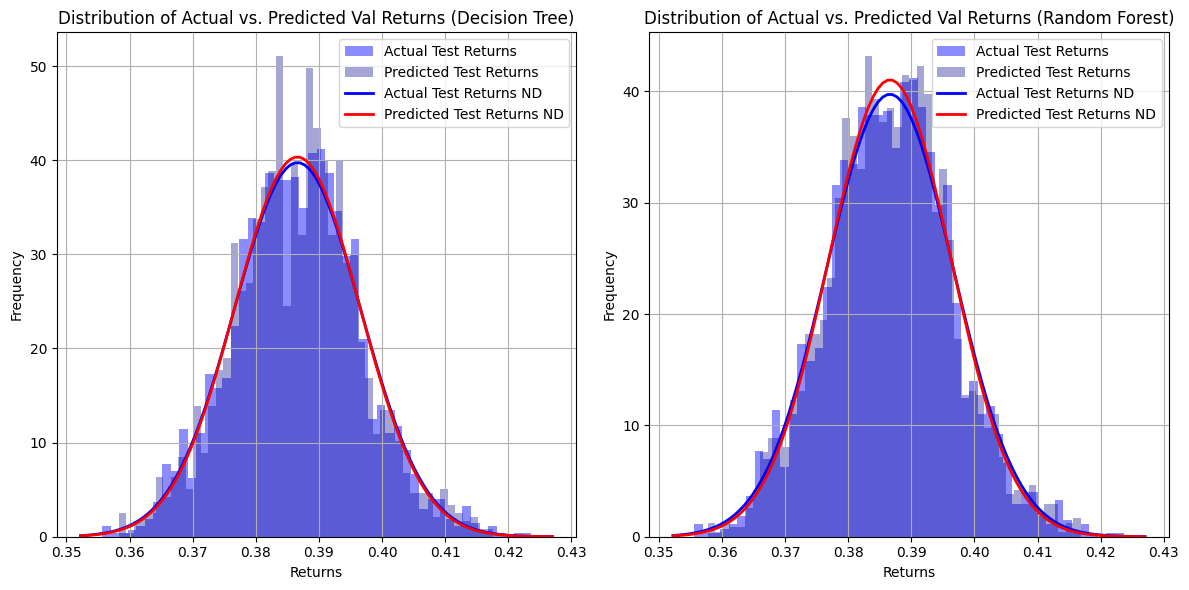

In [221]:

# Setup the plots
plt.figure(figsize=(12, 6))

# Histogram plot for training data
plt.subplot(1, 2, 1)
plt.hist(y_val, bins=50, alpha=0.45, label='Actual Test Returns', color='blue', density=True)
plt.hist(y_val_pred_dt, bins=50, alpha=0.35, label='Predicted Test Returns', color='darkblue', density=True)
plt.title('Distribution of Actual vs. Predicted Val Returns (Decision Tree)')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Overlay normal distribution curve for training data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_actual = norm.pdf(x, np.mean(y_val), np.std(y_val))
p_pred = norm.pdf(x, np.mean(y_val_pred_dt), np.std(y_val_pred_dt))
plt.plot(x, p_actual, 'b', linewidth=2, label="Actual Test Returns ND")
plt.plot(x, p_pred, 'r', linewidth=2, label="Predicted Test Returns ND")

plt.legend()
plt.grid(True)

# Histograms plot for validation (test) data
plt.subplot(1, 2, 2)
plt.hist(y_val, bins=50, alpha=0.45, label='Actual Test Returns', color='blue', density=True)
plt.hist(y_val_pred_rf, bins=50, alpha=0.35, label='Predicted Test Returns', color='darkblue', density=True)
plt.title('Distribution of Actual vs. Predicted Val Returns (Random Forest)')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Overlay normal distribution curve for validation data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_actual = norm.pdf(x, np.mean(y_val), np.std(y_val))
p_pred = norm.pdf(x, np.mean(y_val_pred_rf), np.std(y_val_pred_rf))
plt.plot(x, p_actual, 'b', linewidth=2, label="Actual Test Returns ND")
plt.plot(x, p_pred, 'r', linewidth=2, label="Predicted Test Returns ND")

plt.legend()
plt.grid(True)

# Display histogram plots
plt.tight_layout()
plt.show()


## **6.4** **Impact of External Factors on $ML$ Strategies**

We will briefly outline and explore how external factors affect the performance and feasibility of machine learning-based portfolio optimisation strategies.
	
- Transaction costs: high-frequency trading strategies based on machine learning can incur significant transaction costs, which can erode profits. By simulating a trading strategy with and without transaction costs, you can determine the impact on net returns.
		
- Market liquidity: machine learning models might identify arbitrage opportunities in illiquid stocks. However, due to low liquidity, executing large trades can be challenging. Assessing the liquidity of assets in the portfolio and comparing the model's performance on liquid verse illiquid assets can provide insights.

- Model complexity: while deep learning models can capture complex patterns, they require extensive computational resources and can be prone to overfitting. Comparing the performance of a deep neural network ($DNN$) with a simpler model like linear regression or a Decision Tree can shed light on the trade-off between model complexity and performance.

It's essential to consider transaction costs, market liquidity, and model complexity, as these can influence the feasibility and effectiveness of machine learning models in a real-world scenario.

## **Future Research**

While this project explored traditional machine learning models like Decision Trees and Random Forests, the application of deep learning methods, such as Recurrent Neural Networks ($RNNs$) or long short-term memory networks ($LSTMs$), could be valuable. These models have proven adept at capturing complex temporal patterns in data, which may be particularly relevant for financial time series. 

Seperately, we could explore other machine learning models such as Neural Networks which are complex structures inspired by human brain function - they consist of layers of interconnected nodes or neurons. More about this in the Additional section.

Incorporating alternative data, such as social media sentiment, macroeconomic indicators, or news analytics, could provide richer models. Understanding how these diverse data streams influence asset prices and portfolio performance can unveil novel investment strategies. 

The dynamic nature of portfolio optimisation aligns well with reinforcement learning paradigms, where an agent learns an optimal policy to allocate assets over time. Exploring models like Deep $Q$-Learning or Proximal Policy Optimisation in the context of portfolio management could be groundbreaking.

Lastly, rather than treating classical and machine learning models as separate entities, a hybrid approach that synergistically combines the strengths of methods like $CAPM$ 
or $MVO$ with machine learning could yield innovative strategies. An example might be, instead of simulating portfolios with random asset weighting for Random Forests, we can use the optimised asset weights which were deduced using $MVO$.

## **Conclusion**

This project embarked on an exploratory journey to understand the merging of portfolio optimisation and machine learning techniques, aiming to decipher whether machine learning offers a tangible advantage over traditional methods.

Our analysis revealed that machine learning algorithms, particularly Random Forests, demonstrated a notable capability in capturing the non-linear relationships inherent in financial datasets. These models were able to unearth intricate patterns and dependencies which classical models might overlook.

Comparatively, while classical methods like Mean-Variance Optimisation and the Capital Asset Pricing Model offer a robust theoretical foundation, they come with underlying assumptions that may not always hold true in the chaotic world of financial markets. Whereas, machine learning models, with their data-driven approach, showed potential in navigating this chaos.

However, the integration of machine learning into portfolio management is not without its challenges. Considerations like transaction costs, market liquidity, and model complexity introduce layers of difficulty. Moreover, the black-box nature of many machine learning algorithms necessitates rigorous validation to ensure that they don't merely overfit historical data but genuinely offer predictive power.

This project underscores that machine learning, when wielded judiciously, can be a potent tool; and how it’s essential to approach this intersection of finance and technology with a balanced perspective, leveraging the strengths of both traditional financial models and advanced machine learning algorithms to achieve optimal portfolio performance.


## **Additional**

This project will recieve an update on $01/01/24$ (hopefully) to account for any errors made and implement new models like - Artifical Neural Networks ($ANN$) and include hybrid models which were mentioned in the future research section. For example, instead of simulating random portfolios for Random Forests, we can implement a model where we take the optimised portfolio weights deduced using $MVO$.

## **References**

1. Markowitz, Harry. "Portfolio Selection." 1952.
  
2. Campbell, John Y. and Lo, Andrew W. and MacKinlay, A. Craig. "The Econometrics of Financial Markets." 1997.
  
3. Fama, Eugene F. and French, Kenneth R.. "The Cross-Section of Expected Stock Returns." 1992.
  
4. Gu, Shihao and Xiong, Bryan and Zhang, Hongyang and Zhu, Zhening. "A Machine Learning Approach to Portfolio Optimization." 2020.
  
5. Tsay, Ruey S.. "Analysis of Financial Time Series." 2005.
  
6. James, Gareth and Witten, Daniela and Hastie, Trevor and Tibshirani, Robert. "An Introduction to Statistical Learning: with Applications in R." 2013.
  
7. Sharpe, William F.. "Capital asset prices: A theory of market equilibrium under conditions of risk." 1964.
  
8. Bodie, Zvi and Kane, Alex and Marcus, Alan J.. "Investments." 2005.
  
9. Bengio, Yoshua and Simard, Patrice and Frasconi, Paolo. "Learning long-term dependencies with gradient descent is difficult." 1994.
  
10. Hastie, Trevor and Tibshirani, Robert and Friedman, Jerome. "The Elements of Statistical Learning: Data Mining, Inference, and Prediction." 2009.
  
11. Bailey, David H. and Borwein, Jonathan M. and López de Prado, Marcos and Zhu, Qiji J.. "Pseudo-Mathematics and Financial Charlatanism: The Effects of Backtest Overfitting on Out-of-Sample Performance." 2014.
  
12. Moody, John and Wu, Lizhen and Liao, Yuansong and Saffell, Matthew. "Performance functions and reinforcement learning for trading systems and portfolios." 1998.


**By Shaan Patankar**